In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 15a

### Using artificial data

## Sequential Modeling Regression
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

2024-07-20 10:55:51.152719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 10:55:51.165594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 10:55:51.169287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 10:55:51.179149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 10:55:52.036665: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 50

BATCH_SIZE = 64
# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1721453152.585775   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721453152.629774   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721453152.634102   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Create Some Regression data

In [5]:
start = -2.1
end = 2.1

### Training data

delta = 0.0005

X_train = np.arange(start, end+ delta,delta)
y_rnd = np.random.rand(X_train.shape[0]) - 0.5
y_true =   2* np.square(X_train) + 2 * np.sin(np.pi*X_train)
y_train = y_true + y_rnd* 2

### Test data
X_test = np.arange(start, end+ delta, delta * 10 )
y_rnd = np.random.rand(X_test.shape[0])- 0.5
y_true_test =   2* np.square(X_test) + 2 * np.sin(np.pi*X_test)
y_test = y_true_test  + y_rnd* 2

In [6]:
num_examples = BATCH_SIZE * 131

X_train = X_train[:num_examples]
y_train = y_train[:num_examples]
y_true = y_true[:num_examples]

In [7]:
X_train.shape

(8384,)

In [8]:
X_train.max(), X_test.max()

(2.0915000000013992, 2.0999999999999104)

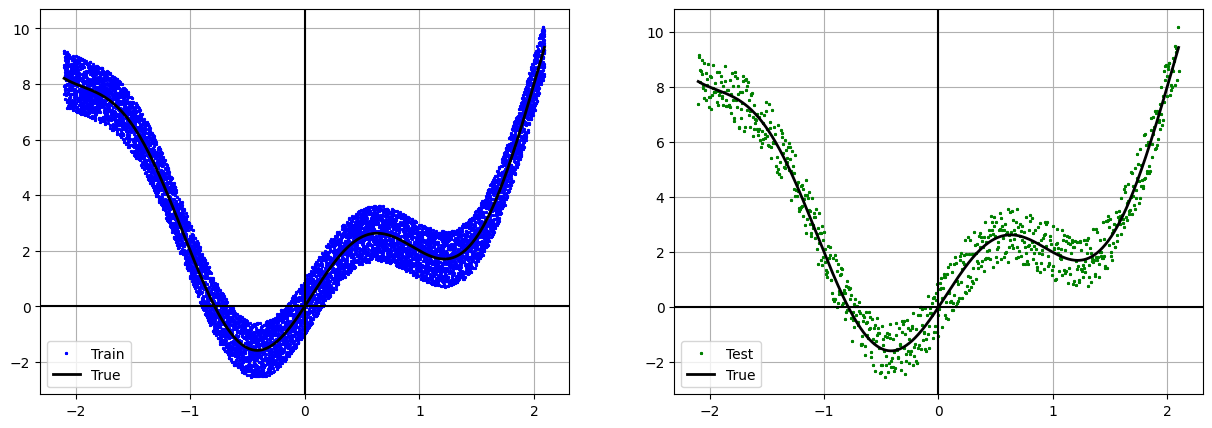

In [9]:
start = -2
end = 2
delta_train = 0.01

fig, axes = plt.subplots(1, 2, figsize =(15,5))

ax = axes[0]
ax.plot(X_train, y_train, 'b*', markersize=2, label = 'Train')
ax.plot(X_train,  y_true, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(X_test, y_test, 'g*', markersize=2, label = 'Test')
ax.plot(X_test,  y_true_test, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend();

In [10]:
# What shape of Input layer?
num_features = 1

#initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# Define Model

# Define the input layer
input_layer = tf.keras.layers.Input(shape=(1,))  # Assuming input shape is (784,)

# Add a hidden layer with 128 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)

# Add another hidden layer with 64 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(64, activation='relu')(hidden_layer)

# Add the output layer with 10 neurons (for a classification task) and softmax activation
output_layer = tf.keras.layers.Dense(1)(hidden_layer)

# Create the model by specifying the input and output layers
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

I0000 00:00:1721453152.918587   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721453152.922993   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721453152.927124   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721453153.079327   75805 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
# Compile the model with a specific optimizer, loss function, and metrics

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['mae'])

In [12]:
# fit the model
history = model.fit(X_train, y_train, 
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    epochs=EPOCHS, 
                    verbose=2)

Epoch 1/50


I0000 00:00:1721453153.687496   75887 service.cc:146] XLA service 0x70716c009e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721453153.687522   75887 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-20 10:55:53.703841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 10:55:53.795806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1721453155.219368   75887 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 - 3s - 22ms/step - loss: 5.7784 - mae: 1.8640 - val_loss: 2.4567 - val_mae: 1.2876
Epoch 2/50
131/131 - 0s - 923us/step - loss: 1.7907 - mae: 1.0812 - val_loss: 1.3369 - val_mae: 0.9019
Epoch 3/50
131/131 - 0s - 917us/step - loss: 1.2621 - mae: 0.8770 - val_loss: 1.2241 - val_mae: 0.8510
Epoch 4/50
131/131 - 0s - 946us/step - loss: 1.1852 - mae: 0.8432 - val_loss: 1.1659 - val_mae: 0.8310
Epoch 5/50
131/131 - 0s - 1ms/step - loss: 1.1102 - mae: 0.8196 - val_loss: 1.0715 - val_mae: 0.8035
Epoch 6/50
131/131 - 0s - 958us/step - loss: 1.0077 - mae: 0.7884 - val_loss: 0.9570 - val_mae: 0.7696
Epoch 7/50
131/131 - 0s - 858us/step - loss: 0.8916 - mae: 0.7501 - val_loss: 0.8341 - val_mae: 0.7277
Epoch 8/50
131/131 - 0s - 849us/step - loss: 0.7750 - mae: 0.7065 - val_loss: 0.7162 - val_mae: 0.6833
Epoch 9/50
131/131 - 0s - 896us/step - loss: 0.6690 - mae: 0.6617 - val_loss: 0.6137 - val_mae: 0.6418
Epoch 10/50
131/131 - 0s - 883us/step - loss: 0.5779 - mae: 0.6202 - val_loss: 0.5285 -

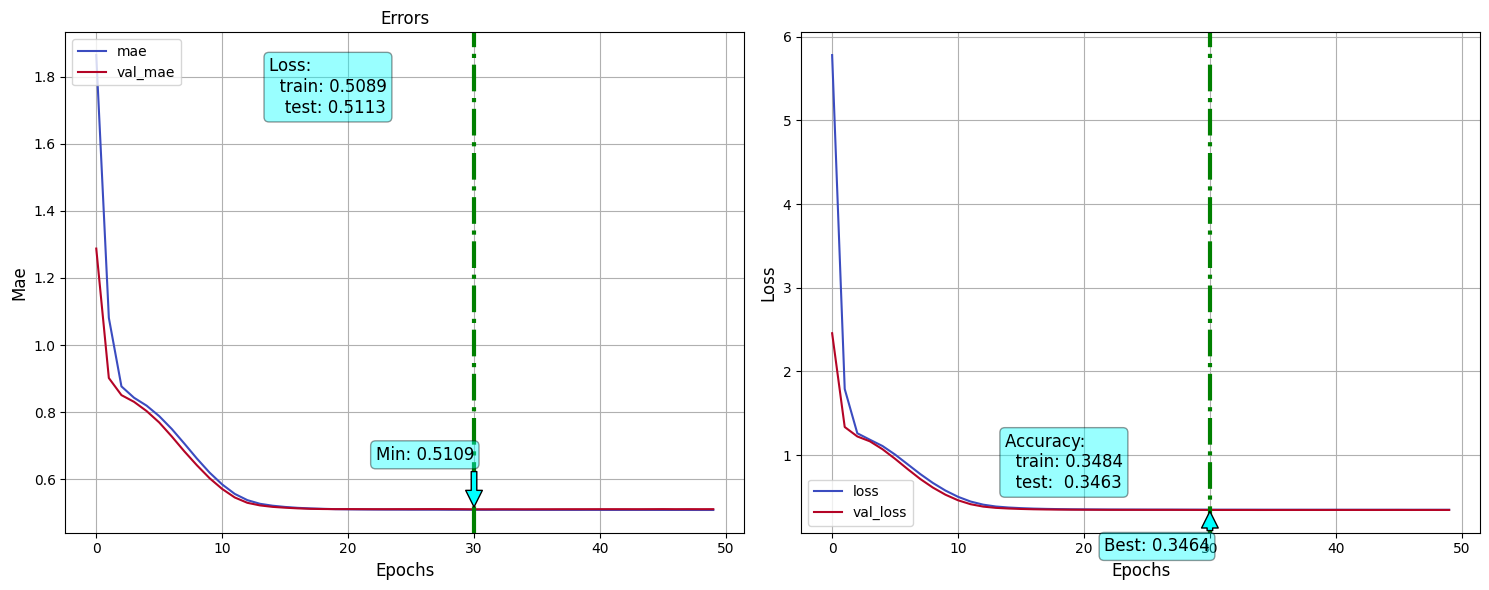

In [13]:
hist_df = pd.DataFrame(history.history)

fn_plot_tf_hist(hist_df)

In [14]:
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {error[0]:.3f}, MAE: {np.sqrt(error[1]):.3f}')

Loss: 0.346, MAE: 0.715


In [15]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred' : y_pred[:,0], 'test' : y_test} )

results_df['y_true'] = y_true_test

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


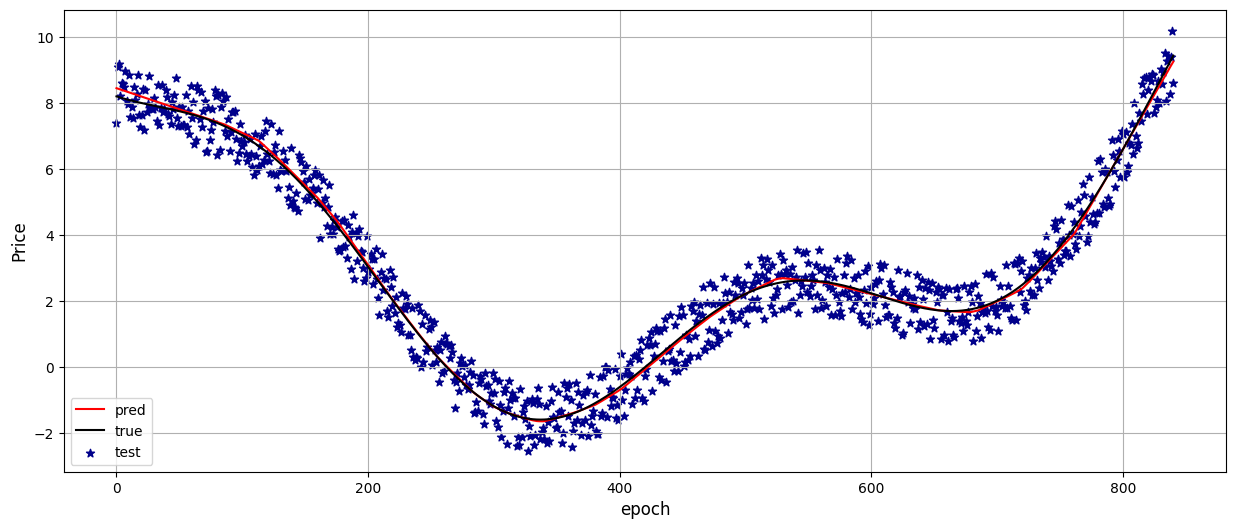

In [16]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker ='*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid()
plt.legend()
plt.show()

In [17]:
# What shape of Input layer?
num_features = 1

initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# define model
model = tf.keras.Sequential()

model.add( tf.keras.layers.Dense(128, 
                                 activation='swish', 
                                 kernel_initializer=initializer, 
                                 input_shape=(num_features,)))

model.add(tf.keras.layers.Dense(64, 
                                activation='swish', 
                                kernel_initializer=initializer))

model.add(tf.keras.layers.Dense(1))

/home/pks/Sep2024/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# compile the model
model.compile(optimizer='adam', loss='mse')

In [19]:
# fit the model
history = model.fit(X_train, y_train, 
          batch_size = BATCH_SIZE,
          validation_data=[X_test, y_test],
          epochs=EPOCHS, 
          verbose=2)

Epoch 1/50
131/131 - 1s - 8ms/step - loss: 2.0571 - val_loss: 1.0255
Epoch 2/50
131/131 - 0s - 870us/step - loss: 0.9165 - val_loss: 0.7712
Epoch 3/50
131/131 - 0s - 857us/step - loss: 0.7281 - val_loss: 0.6457
Epoch 4/50
131/131 - 0s - 874us/step - loss: 0.6367 - val_loss: 0.5747
Epoch 5/50
131/131 - 0s - 1ms/step - loss: 0.5756 - val_loss: 0.5258
Epoch 6/50
131/131 - 0s - 906us/step - loss: 0.5243 - val_loss: 0.4982
Epoch 7/50
131/131 - 0s - 878us/step - loss: 0.4835 - val_loss: 0.4874
Epoch 8/50
131/131 - 0s - 857us/step - loss: 0.4513 - val_loss: 0.4776
Epoch 9/50
131/131 - 0s - 883us/step - loss: 0.4251 - val_loss: 0.4679
Epoch 10/50
131/131 - 0s - 882us/step - loss: 0.4060 - val_loss: 0.4556
Epoch 11/50
131/131 - 0s - 904us/step - loss: 0.3932 - val_loss: 0.4427
Epoch 12/50
131/131 - 0s - 861us/step - loss: 0.3848 - val_loss: 0.4329
Epoch 13/50
131/131 - 0s - 852us/step - loss: 0.3793 - val_loss: 0.4262
Epoch 14/50
131/131 - 0s - 861us/step - loss: 0.3757 - val_loss: 0.4217
Epoch

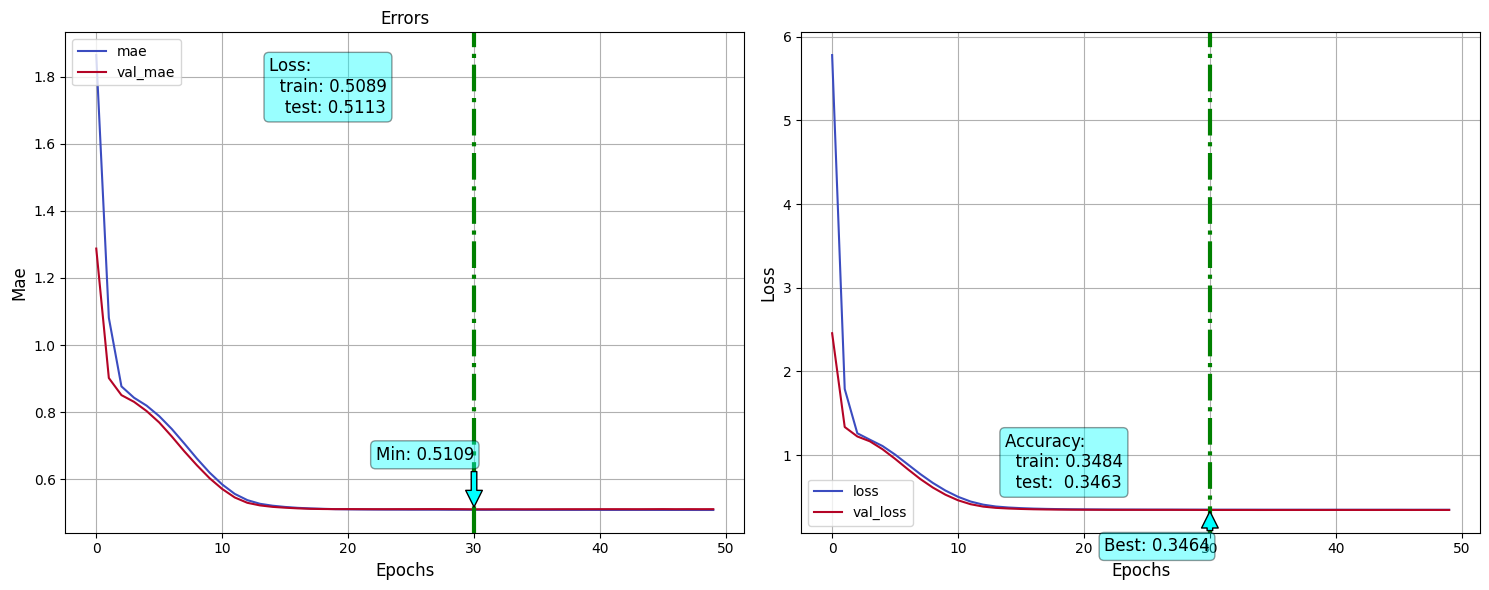

In [20]:
fn_plot_tf_hist(pd.DataFrame(hist_df))

In [21]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred' : y_pred[:, 0], 'test' : y_test} )

results_df['y_true'] = y_true_test

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


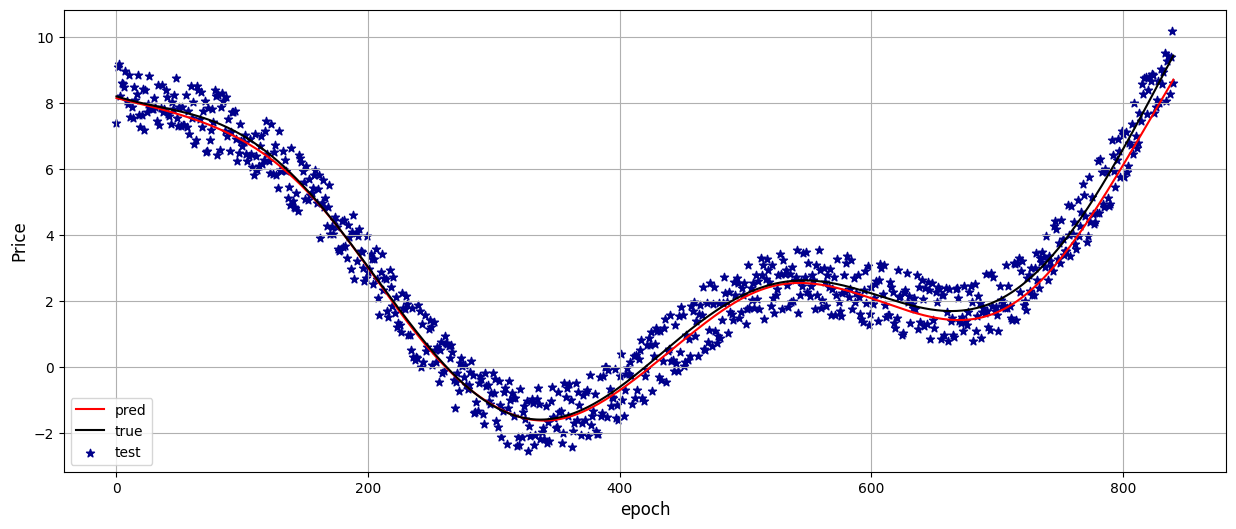

In [22]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker ='*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid()
plt.legend()
plt.show()